NameError: name 'date' is not defined

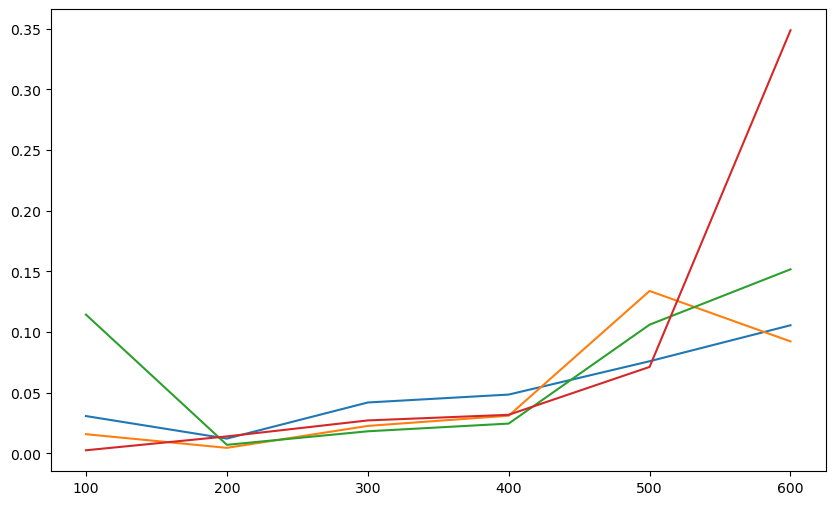

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

def parallel_matrix_multiplication(A, B, num_cpus):
    """
    Performs matrix multiplication in parallel using multiple cores.

    Args:
        A: First numpy matrix.
        B: Second numpy matrix.
        num_cpus: The number of CPUs to use for parallelization.

    Returns:
        The resulting product matrix.
    """
    with ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = []
        for i in range(len(A)):
            futures.append(executor.submit(np.matmul, A[i], B))
        results = [f.result() for f in concurrent.futures.as_completed(futures)]
    return np.array(results)

# Define matrix dimensions (experiment with larger sizes for better speedup)
matrix_sizes = [100, 200, 300, 400, 500, 600]

# Number of CPU cores to use
num_cpus = [1, 2, 4, 8]

parallel_times = np.zeros((len(matrix_sizes), len(num_cpus)))

# Measure execution times
for i, size in enumerate(matrix_sizes):
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    for j, cpu_count in enumerate(num_cpus):
        # Parallel execution
        start_time = time.time()
        C_parallel = parallel_matrix_multiplication(A, B, cpu_count)
        parallel_times[i][j] = time.time() - start_time

# Plot the results
plt.figure(figsize=(10, 6))
for j, cpu_count in enumerate(num_cpus):
    plt.plot(matrix_sizes, parallel_times[:, j], label=f'Parallel (CPU={cpu_count})')

plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.title('Parallel Matrix Multiplication')
plt.legend()
plt.grid()
plt.show()
